In [1]:
import os,sys
import random
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
### Enter the data folder name and WCR information

# Load the data folder path
path = os.getcwd()
path_upper = path + '/data_mortar'

# WCR information
WC_name_tag = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]

# Fit the random seed
seed_data = 4885
random.seed(seed_data)
np.random.seed(seed_data)
os.environ["PYTHONHASHSEED"] = str(seed_data)
tf.random.set_seed(seed_data)

# Set the name of the training model file to save.
last_model_save_name = "WCRnet_18_layers.h5"
last_model_save_dir = path + f'/save_models/{last_model_save_name}'

# Layer paramter for WCRnet
layer_list = [2, 2, 2, 2]

# Parameter for Training
epochs = 1000                 # training epochs
batch_sizes = 1024            # batch size
initial_learning_rate = 0.1   # initial learning rate
input_shape = 6               # input shape of the model

# Parameter for K-FOLD validation
k_fold_num = 4                # number of K-Folds
current_fold = 0              # Set the 'K' : 0 | 1 | 2 | 3

In [3]:
### Data normalization

# Normalize to the minimum and maximum sensor measurement values.
def sense_min_max_Normalization(input_data, min_value, max_value):
    data = (input_data - min_value) / (max_value - min_value) 
    
    return data

def data_set_normalization(data):
    # sensor_min_value
    vwc_min = 0
    ec_min = 0
    salinity_min = 0
    tds_min = 0
    epsilon_min = 0
    temp_min = -40
    
    # sensor_max_value
    vwc_max = 100
    ec_max = 20000
    salinity_max = 20000
    tds_max = 20000
    temp_max = 80
    epsilon_max = 82
    
    # sensor_normalization 
    data['TEMP'] = sense_min_max_Normalization(data['TEMP'],temp_min,temp_max)
    data['EC'] = sense_min_max_Normalization(data['EC'],ec_min,ec_max)
    data['VWC'] = sense_min_max_Normalization(data['VWC'],vwc_min,vwc_max)
    data['TDS'] = sense_min_max_Normalization(data['TDS'],tds_min,tds_max)
    data['SALINITY'] = sense_min_max_Normalization(data['SALINITY'],salinity_min,salinity_max)
    data['EPSILON'] = sense_min_max_Normalization(data['EPSILON'],epsilon_min,epsilon_max)
    
    return data

In [4]:
### Load FDR Data

path_list = []
path_under=os.listdir(path_upper)

# Load data_path
for i in range(len(path_under)): # collect under directory file path
    path_sub=os.listdir(path_upper+'/'+path_under[i])
    
    for j in range(len(path_sub)):
        path_list.append(path_upper+'/'+path_under[i]+'/'+path_sub[j])

# Create the zero matrix
data_list = [0]*len(path_list)
rand_x_data_list = [0]*len(path_list)
rand_y_data_list = [0]*len(path_list)

# Load data_value
for i,j in enumerate(path_list):
    data_list[i] =pd.read_csv(j)
    data_list[i] = data_set_normalization(data_list[i])

# Create the entire dataset.
total_data = pd.concat(data_list)
total_data = total_data.dropna()

# Print the data format
total_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.523083,0.18250,0.6175,0.09125,0.10035,0.690366
1,0.4,0.520667,0.18320,0.6234,0.09160,0.10075,0.698902
2,0.4,0.519000,0.18435,0.6234,0.09215,0.10135,0.698902
3,0.4,0.517917,0.18755,0.6278,0.09375,0.10315,0.705244
4,0.4,0.517000,0.18830,0.6326,0.09415,0.10355,0.711829
...,...,...,...,...,...,...,...
526,0.6,0.487667,0.29310,0.9488,0.14655,0.16120,0.967439
527,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439
528,0.6,0.487667,0.29400,0.9488,0.14700,0.16170,0.967439
529,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439


In [5]:
# GT-label (WCR)
y_R = round(total_data['WC_ratio']*100, 1)
y_data_total = y_R.to_numpy()

# FDR sensor data
x_R = total_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_data_total = x_R.to_numpy()

In [6]:
# split train/test data
tmp_x_train, x_test, tmp_y_train, y_test = train_test_split(x_data_total.astype('float'), y_data_total.astype('float'), test_size=0.2, random_state=seed_data)

# splot train/valid data
x_train_kfold = []
x_valid_kfold = []
y_train_kfold = []
y_valid_kfold = []

kfold = KFold(n_splits=k_fold_num)

for train_idx, valid_idx in kfold.split(tmp_x_train):
    x_train_kfold.append(tmp_x_train[train_idx])
    x_valid_kfold.append(tmp_x_train[valid_idx])
    y_train_kfold.append(tmp_y_train[train_idx])
    y_valid_kfold.append(tmp_y_train[valid_idx])

# Print the quantity of data
print(f"quantity of train data : {len(x_train_kfold[0])}")
print(f"quantity of validation data : {len(x_valid_kfold[0])}")
print(f"quantity of test data : {len(y_test)}")

quantity of train data : 14010
quantity of validation data : 4670
quantity of test data : 4670


In [7]:
### Create WCRnet

print("tf_version : %s" %tf.__version__)

def layer_1(x):    
    x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
 
    return x   
 
    
def layer_2(x):       
 
    for i in range(layer_list[0]): 
        if i==0: 
            # upsample 32 -> 64
            reshaped_input = tf.expand_dims(x, axis=-1)
            upsampled_output = tf.keras.layers.UpSampling1D(size=2)(reshaped_input)
            shortcut = tf.squeeze(upsampled_output, axis=-1)            
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x
      
    return x
 
  
def layer_3(x):        
    
    for i in range(layer_list[1]):  
        if i==0: 
            # upsample 64 -> 128
            reshaped_input = tf.expand_dims(x, axis=-1)
            upsampled_output = tf.keras.layers.UpSampling1D(size=2)(reshaped_input)
            shortcut = tf.squeeze(upsampled_output, axis=-1)
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x
 
  
def layer_4(x):   
    
    for i in range(layer_list[2]): 
        if i==0: 
            # downsample 128 -> 64
            reshaped_input = tf.expand_dims(x, axis=-1)
            downsampled_output  = tf.keras.layers.AveragePooling1D(pool_size=2)(reshaped_input)
            shortcut = tf.squeeze(downsampled_output , axis=-1)
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x
 
  
def layer_5(x):
    
    for i in range(layer_list[3]):
        if i==0: 
            # downsample 64 -> 32
            reshaped_input = tf.expand_dims(x, axis=-1)
            downsampled_output  = tf.keras.layers.AveragePooling1D(pool_size=2)(reshaped_input)
            shortcut = tf.squeeze(downsampled_output , axis=-1)
        else:
            shortcut = x    

        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x

# Learning rate scheduler
def lr_exp_decay(epoch, lr):
    if epoch <50:
        return initial_learning_rate
    
    elif epoch >=50 and epoch <100:
        return initial_learning_rate * 0.1
    
    elif epoch >=100 and epoch <300:
        return initial_learning_rate * 0.01
    
    elif epoch >=300 and epoch <500:
        return initial_learning_rate * 0.001
    
    else:
        return initial_learning_rate * 0.0001

tf_version : 2.6.2


In [8]:
### Compile WCRnet

input_tensor =  tf.keras.Input(shape=(input_shape,))

x = layer_1(input_tensor)
x = layer_2(x)
x = layer_3(x)
x = layer_4(x)
x = layer_5(x)
 
output_tensor = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
output_tensor = tf.keras.activations.relu(output_tensor)

model = tf.keras.Model(input_tensor, output_tensor)
model.summary()

start_model=model.get_weights()
counter  = 0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         dense[0][0]                      
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 32)           0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
### Training WCRnet

train_mode = True

if train_mode == True:
    # Load the learning rate scheduler
    lr_s = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

    # Load the Early Stopping
    early_stop = tf.keras.callbacks.EarlyStopping(patience=300, min_delta=3, monitor='val_loss')    
    
    # model compile
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

    # training
    history = model.fit(x_train_kfold[current_fold], y_train_kfold[current_fold], validation_data=(x_valid_kfold[current_fold], y_valid_kfold[current_fold]), epochs=epochs, batch_size=batch_sizes, callbacks=[lr_s, early_stop])

    # save WCRnet
    model.save(last_model_save_dir)

Epoch 1/1000
14/14 [==============================] - 5s 63ms/step - loss: 515.0244 - val_loss: 1421872384.0000
Epoch 2/1000
14/14 [==============================] - 1s 42ms/step - loss: 23.8721 - val_loss: 1130402.7500
Epoch 3/1000
14/14 [==============================] - 1s 42ms/step - loss: 8.4453 - val_loss: 44735.1875
Epoch 4/1000
14/14 [==============================] - 1s 42ms/step - loss: 4.9315 - val_loss: 6526.5371
Epoch 5/1000
14/14 [==============================] - 1s 44ms/step - loss: 3.7386 - val_loss: 1140.2230
Epoch 6/1000
14/14 [==============================] - 1s 46ms/step - loss: 4.2689 - val_loss: 175.9744
Epoch 7/1000
14/14 [==============================] - 1s 45ms/step - loss: 3.2723 - val_loss: 18.7125
Epoch 8/1000
14/14 [==============================] - 1s 46ms/step - loss: 3.3160 - val_loss: 22.0155
Epoch 9/1000
14/14 [==============================] - 1s 46ms/step - loss: 3.5399 - val_loss: 31.4331
Epoch 10/1000
14/14 [==============================] - 1s 

14/14 [==============================] - 1s 46ms/step - loss: 1.8477 - val_loss: 9.7818
Epoch 81/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.8258 - val_loss: 21.5562
Epoch 82/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.9273 - val_loss: 18.7220
Epoch 83/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.8504 - val_loss: 41.2246
Epoch 84/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.8962 - val_loss: 24.6745
Epoch 85/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.8846 - val_loss: 15.4619
Epoch 86/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.8179 - val_loss: 10.2639
Epoch 87/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.7980 - val_loss: 7.0855
Epoch 88/1000
14/14 [==============================] - 1s 44ms/step - loss: 1.8084 - val_loss: 5.7700
Epoch 89/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.8494 - val_l

14/14 [==============================] - 1s 44ms/step - loss: 1.6641 - val_loss: 2.3038
Epoch 160/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6475 - val_loss: 2.5432
Epoch 161/1000
14/14 [==============================] - 1s 44ms/step - loss: 1.6732 - val_loss: 3.3224
Epoch 162/1000
14/14 [==============================] - 1s 44ms/step - loss: 1.6780 - val_loss: 3.0859
Epoch 163/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.7245 - val_loss: 3.8472
Epoch 164/1000
14/14 [==============================] - 1s 49ms/step - loss: 1.7230 - val_loss: 3.3889
Epoch 165/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6946 - val_loss: 2.9188
Epoch 166/1000
14/14 [==============================] - 1s 44ms/step - loss: 1.7339 - val_loss: 2.6020
Epoch 167/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.6530 - val_loss: 4.3733
Epoch 168/1000
14/14 [==============================] - 1s 43ms/step - loss: 1.6608 - va

14/14 [==============================] - 1s 47ms/step - loss: 1.6672 - val_loss: 2.0216
Epoch 239/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6507 - val_loss: 2.3028
Epoch 240/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6183 - val_loss: 5.5537
Epoch 241/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.7657 - val_loss: 5.3776
Epoch 242/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6616 - val_loss: 5.1552
Epoch 243/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.5976 - val_loss: 9.0003
Epoch 244/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.6197 - val_loss: 10.2495
Epoch 245/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.7280 - val_loss: 8.5325
Epoch 246/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6189 - val_loss: 3.9895
Epoch 247/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6373 - v

14/14 [==============================] - 1s 46ms/step - loss: 1.6054 - val_loss: 1.6051
Epoch 318/1000
14/14 [==============================] - 1s 46ms/step - loss: 1.5436 - val_loss: 1.6502
Epoch 319/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5551 - val_loss: 1.6042
Epoch 320/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5945 - val_loss: 1.5832
Epoch 321/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.6238 - val_loss: 1.6134
Epoch 322/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5426 - val_loss: 1.5805
Epoch 323/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5791 - val_loss: 1.6021
Epoch 324/1000
14/14 [==============================] - 1s 48ms/step - loss: 1.7010 - val_loss: 1.6075
Epoch 325/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5444 - val_loss: 1.6028
Epoch 326/1000
14/14 [==============================] - 1s 47ms/step - loss: 1.5614 - va

14/14 [==============================] - 1s 45ms/step - loss: 1.4863 - val_loss: 1.5625
Epoch 397/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5402 - val_loss: 1.5529
Epoch 398/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5223 - val_loss: 1.5692
Epoch 399/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5355 - val_loss: 1.5572
Epoch 400/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5149 - val_loss: 1.5654
Epoch 401/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.6300 - val_loss: 1.5712
Epoch 402/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5902 - val_loss: 1.5621
Epoch 403/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.6417 - val_loss: 1.6158
Epoch 404/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.4897 - val_loss: 1.5687
Epoch 405/1000
14/14 [==============================] - 1s 45ms/step - loss: 1.5138 - va

C:\Users\cai-sh\anaconda3\envs\wc_ratio\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


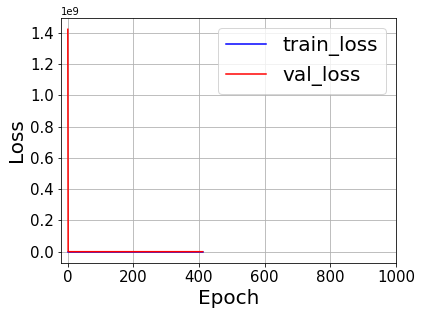

In [10]:
### Plot the Loss graph

if train_mode == True:
    plt.subplots(figsize=(6,4.5))
    plt.plot(history.history['loss'],'b-',label='train_loss')
    plt.plot(history.history['val_loss'],'b-',label='val_loss',color='r')

    plt.legend(prop={'size': 20})

    plt.xlabel("Epoch", fontdict={'size': 20})
    plt.ylabel("Loss", fontdict={'size': 20})

    plt.xticks((0, 200, 400, 600, 800, 1000),fontsize=15)
    plt.yticks(fontsize=15)

    plt.grid(True)
    plt.show()

In [11]:
### Print the prediction results

test_losses = []
p_result_0 = []

# Load Model & Make Results
model.load_weights(last_model_save_dir)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

test_losses = model.evaluate(x_test, y_test, verbose=0)
p_result_0 = model.predict(x_test)

p_result_0

array([[60.01006 ],
       [55.102154],
       [49.719532],
       ...,
       [40.021755],
       [49.285503],
       [55.050533]], dtype=float32)

In [12]:
### print RMSE and R2-score

rmse_0 = round(mean_squared_error(y_test, p_result_0, squared=False), 4)
r2_0 = round(r2_score(y_test, p_result_0), 4)

print(f"RMSE : {rmse_0}")
print(f"r2_score : {r2_0}")

RMSE : 1.2555
r2_score : 0.9624


In [13]:
# Preprocess the results (group by the same y-value).
p_list_0 = [[]for i in range(len(WC_name_tag))]

for i,test_water in enumerate(y_test):    
    for j,wc_name in enumerate(WC_name_tag):
        
        if i==len(y_test):
            break
            
        # If the actual water-cement ratio and the estimated water-cement ratio are the same, append to p_list.
        if(np.round(test_water,3)==wc_name):
            p_list_0[j].append(p_result_0[i])
         
p_list_0

[[array([40.07079], dtype=float32),
  array([40.282543], dtype=float32),
  array([40.03948], dtype=float32),
  array([39.86333], dtype=float32),
  array([39.847424], dtype=float32),
  array([40.084904], dtype=float32),
  array([40.113537], dtype=float32),
  array([40.15471], dtype=float32),
  array([39.797115], dtype=float32),
  array([39.978504], dtype=float32),
  array([40.05434], dtype=float32),
  array([40.147015], dtype=float32),
  array([40.135242], dtype=float32),
  array([40.129044], dtype=float32),
  array([40.138332], dtype=float32),
  array([40.095997], dtype=float32),
  array([39.850063], dtype=float32),
  array([40.257587], dtype=float32),
  array([40.651897], dtype=float32),
  array([40.00462], dtype=float32),
  array([40.64669], dtype=float32),
  array([40.51406], dtype=float32),
  array([39.92339], dtype=float32),
  array([40.088234], dtype=float32),
  array([39.923107], dtype=float32),
  array([40.059895], dtype=float32),
  array([40.058872], dtype=float32),
  array([4

In [14]:
### Print the mean and standard deviation of the predicted WCR (Water-Cement Ratio).

p_list_mean = [[]for i in range(len(WC_name_tag))]
p_list_std = [[]for i in range(len(WC_name_tag))]

for i in range(len(WC_name_tag)):
    tmp_mean = np.mean(p_list_0[i])
    tmp_std = np.std(p_list_0[i])
    
    p_list_mean[i].append(tmp_mean)
    p_list_std[i].append(tmp_std)

flattened_mean = [item for sublist in p_list_mean for item in sublist]
flattened_std = [item for sublist in p_list_std for item in sublist]

print(f"meanb per WCR: {flattened_mean}\n")
print(f"std per WCR: {flattened_std}")

meanb per WCR: [40.317135, 43.312965, 45.255993, 46.609375, 49.47439, 52.145008, 54.54123, 57.211876, 59.90907]

std per WCR: [0.9910516, 1.3378135, 1.1611304, 1.2302959, 1.5304419, 1.4786953, 0.96794146, 0.67143494, 0.5263302]


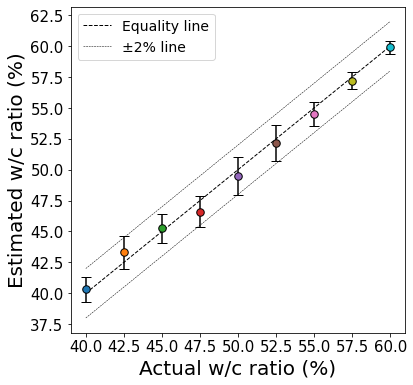

In [15]:
### Plot graph

x_axis = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]
y_axis = [37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(figsize=(6, 6))

for i, tmp_color in enumerate(colors):
    ax.errorbar(WC_name_tag[i], flattened_mean[i], yerr=flattened_std[i], linestyle='None', markeredgecolor='k', ecolor='k', marker='o', markersize=7.5, color=tmp_color, capsize=5, elinewidth=1.5)

# equal line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], c='k', ls='--', lw=1, label='Equality line')

# upper line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [42, 44.5, 47, 49.5, 52, 54.5, 57, 59.5, 62], c='k', ls='--', lw=0.5, label='±2% line')

# under lone
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [38, 40.5, 43, 45.5, 48, 50.5, 53, 55.5, 58], c='k', ls='--', lw=0.5)

plt.xlabel('Actual w/c ratio (%)', fontdict={'size': 20})
plt.ylabel('Estimated w/c ratio (%)', fontdict={'size': 20})
plt.xticks(x_axis, fontsize=15)
plt.yticks(y_axis, fontsize=15)
plt.legend(fontsize=14)

plt.show()